In [70]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import RobustScaler, StandardScaler
import random
import matplotlib.pyplot as plt
import time

plt.style.use('default')

In [71]:

# --- Add this near the top of your script ---
def set_seed(seed_value=42):
    """Sets the seed for reproducibility in PyTorch, NumPy, and Python."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value) # Numpy module
    torch.manual_seed(seed_value) # PyTorch CPU seeding

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
        # Configure CuDNN for deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # Optional: Newer PyTorch versions might require this for full determinism
        # Note: This can sometimes throw errors if a deterministic implementation isn't available
        # try:
        #     torch.use_deterministic_algorithms(True)
        # except Exception as e:
        #     print(f"Warning: Could not enable deterministic algorithms: {e}")
        # Optional: Sometimes needed for deterministic matrix multiplication
        # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    print(f"Seed set globally to {seed_value}")



# --- Call this function very early in your script ---
SEED = 42 # Choose your desired seed value
set_seed(SEED)


Seed set globally to 42


In [90]:
static_variables = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
categorical_vars = ["Gender","GCS", "MechVent"]
static_variables_we_want = ['Age', 'Gender', 'Height', 'Weight']
all_variables = ['Weight', 'Age', 'TroponinI', 'DiasABP', 'MechVent', 'HCO3', 'Cholesterol', 'HCT', 'SaO2', 'WBC', 'SysABP', 'Urine', 'ICUType', 'Gender', 'ALP', 'Creatinine', 'K', 'AST', 'Glucose', 'RespRate', 'MAP', 'FiO2', 'BUN', 'Na', 'Bilirubin', 'TroponinT', 'PaCO2', 'Height', 'GCS', 'HR', 'pH', 'PaO2', 'Lactate', 'ALT', 'NISysABP', 'RecordID', 'Platelets', 'Temp', 'Mg', 'NIDiasABP', 'Albumin', 'NIMAP']
dyn_variables = [x for x in all_variables if x not in static_variables]
dyn_variables.append('Weight_VAR')

print(len(dyn_variables), len(static_variables_we_want))

37 4


In [91]:
train_df = pd.read_parquet("data/set-a_no_nan.parquet")
val_df = pd.read_parquet("data/set-b_no_nan.parquet")
test_df = pd.read_parquet("data/set-c_no_nan.parquet")

outcomes_a_df = pd.read_csv("data/Outcomes-a.txt", sep=",")
outcomes_b_df = pd.read_csv("data/Outcomes-b.txt", sep=",")
outcomes_c_df = pd.read_csv("data/Outcomes-c.txt", sep=",")

In [96]:
tmp_outcomes = [outcomes_a_df, outcomes_b_df, outcomes_c_df]

data_df = [train_df, val_df, test_df]

outcome_labels = []
for i in range(3):
    outcome_records = tmp_outcomes[i]['RecordID'].unique().astype(int)
    train_records = data_df[i]['RecordID'].unique().astype(int)
    assert (outcome_records - train_records == 0).all(), "Mismatch: expected difference of 0 between outcome_records and train_records."

    outcome_labels.append(tmp_outcomes[i]["In-hospital_death"].values) # 1 if patient died in hospital, 0 otherwise
    print(outcome_labels[i].shape, type(outcome_labels[i]))
print("All records in outcomes and data are in same order")

(4000,) <class 'numpy.ndarray'>
(4000,) <class 'numpy.ndarray'>
(4000,) <class 'numpy.ndarray'>
All records in outcomes and data are in same order


In [97]:
# Convert dfs into numpy arrays
def convert_df_to_np(df):
    dfs = []
    for record_id in df['RecordID'].unique():
        df_tmp = df[df['RecordID'] == record_id]
        df_tmp = df_tmp.drop(columns=['RecordID', "Time"])
        arr = df_tmp.to_numpy()
        dfs.append(arr)

    # convert list of dfs to list of tensors
    train_data = np.array(dfs)
    return train_data


train_data = convert_df_to_np(data_df[0])
val_data = convert_df_to_np(data_df[1])
test_data = convert_df_to_np(data_df[2])

y_train = outcome_labels[0]
y_val = outcome_labels[1]
y_test = outcome_labels[2]


# Standardize data
# Original shape: (n_patients, n_timepoints, n_features)
n_patients, n_timepoints, n_features = train_data.shape

# Reshape to 2D: (n_patients * n_timepoints, n_features)
train_data_2d = train_data.reshape(-1, n_features)
val_data_2d = val_data.reshape(-1, n_features)
test_data_2d = test_data.reshape(-1, n_features)

# Initialize and fit the scaler ONLY on training data
scaler = RobustScaler()
scaler.fit(train_data_2d)

# Transform all datasets
train_scaled_2d = scaler.transform(train_data_2d)
val_scaled_2d = scaler.transform(val_data_2d)
test_scaled_2d = scaler.transform(test_data_2d)

# Reshape back to 3D
train_data = train_scaled_2d.reshape(n_patients, n_timepoints, n_features)
val_data = val_scaled_2d.reshape(val_data.shape)
test_data = test_scaled_2d.reshape(test_data.shape)

print("Sklearn Standard scaled train data shape:", train_data.shape)



Sklearn Standard scaled train data shape: (4000, 49, 41)


In [76]:

class MedicalTimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].unsqueeze(-1)

In [77]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_length=49):
        super().__init__()

        pe = torch.zeros(max_length, d_model) # max_length: number tokens, d_model: dimension of each token (embedding dim)

        position = torch.arange(0, max_length).unsqueeze(1) # shape (max_length, 1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2)* -(torch.log(torch.tensor(10000.0)) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))
        self.pe: torch.Tensor

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TimeSeriesTransformer(nn.Module):

    def __init__(self, feature_dim = 41, d_model = 128, nhead = 4, num_layers = 2,dropout=0.1) -> None:
        super().__init__()

        self.d_model = d_model
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
            )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2) # transformer expects (seq_len, batch, features)
        x = self.transformer_encoder(x)
      
        x = x[-1, :, :] # last time step

        x = self.classifier(x)
        return x

In [78]:
# --- Training and Evaluation Functions ---

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for i, (batch_X, batch_y) in enumerate(loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        # Gradient clipping (optional but can help stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        # Print progress (optional)
        # if (i + 1) % 50 == 0:
        #      elapsed = time.time() - start_time
        #      print(f'  Batch {i+1}/{len(loader)}, Loss: {loss.item():.4f}, Time: {elapsed:.2f}s')
        #      start_time = time.time() # Reset timer

    avg_loss = total_loss / len(loader)
    return avg_loss

def evaluate(model, loader, criterion, device, return_probs=False):
    model.eval()
    total_loss = 0.0
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X) # raw logits
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            all_logits.extend(outputs.cpu())
            all_labels.extend(batch_y.cpu())

    avg_loss = total_loss / len(loader)
    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy().flatten()

    all_probs = 1/ (1+ np.exp(-all_logits)).flatten() # Sigmoid to get probabilities

    all_preds_05 = np.where(all_probs > 0.5, 1, 0).astype(int) # Convert probabilities to binary predictions
    # Calculate metrics
    try:
        auc = roc_auc_score(all_labels, all_preds_05) # Use probabilities for AUC if needed: roc_auc_score(all_labels, probs.flatten())
    except ValueError:
        print("Warning: ROC AUC calculation failed. Likely only one class present in this evaluation batch/set.")
        auc = 0.0 # Or handle as appropriate

    f1 = f1_score(all_labels, all_preds_05)
    acc = accuracy_score(all_labels, all_preds_05)
    prec = precision_score(all_labels, all_preds_05, zero_division=0)
    rec = recall_score(all_labels, all_preds_05, zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_preds_05)

    metrics = {
        'loss': avg_loss,
        'auc': auc,
        'f1': f1,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'conf_matrix': conf_mat
    }
    if return_probs:
        return metrics, all_probs, all_labels
    else:
        return metrics

def find_best_threshold_f1(probs, labels):
    """
    Finds the probability threshold that maximizes F1 score.
    Args:
        probs (np.array): Probabilities for the positive class.
        labels (np.array): True binary labels.
    Returns:
        tuple: (best_threshold, best_f1_score)
    """
    thresholds = np.arange(0.01, 1.0, 0.01) # Range of thresholds to check
    f1_scores = []
    for thresh in thresholds:
        preds = (probs >= thresh).astype(int)
        f1 = f1_score(labels, preds)
        f1_scores.append(f1)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"Best Threshold for F1: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

    # Optional: Plot F1 score vs threshold
    plt.figure()
    plt.plot(thresholds, f1_scores)
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs. Prediction Threshold (Validation Set)")
    plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Optional: Plot Precision-Recall Curve
    precisions, recalls, pr_thresholds = precision_recall_curve(labels, probs)
    # Find threshold closest to the best F1 threshold (pr_thresholds may not exactly match np.arange)
    closest_pr_thresh_idx = np.argmin(np.abs(pr_thresholds - best_threshold))

    plt.figure()
    plt.plot(recalls, precisions, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Validation Set)")
    plt.plot(recalls[closest_pr_thresh_idx], precisions[closest_pr_thresh_idx], 'ro', ms=8, label=f'Point near Best F1 Threshold ({best_threshold:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()


    return best_threshold, best_f1

In [79]:
# --- Hyperparameters and Setup ---
model_save_path = "./data/V7_1_best_transformer_model_weighted_sampler_dropout03.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print("Using device:", DEVICE)

BATCH_SIZE = 32 # Adjust based on GPU memory
LEARNING_RATE = 1e-4 # Common starting point for transformers
WEIGHT_DECAY = 1e-4 # AdamW uses weight decay
EPOCHS = 30 # Start with a reasonable number, monitor validation loss/AUC
D_MODEL = 128
N_HEAD = 2
NUM_LAYERS = 2
DROPOUT = 0.3 # Increased dropout slightly


# --- Create Datasets and DataLoaders ---
train_dataset = MedicalTimeSeriesDataset(train_data, y_train)
val_dataset = MedicalTimeSeriesDataset(val_data, y_val)
test_dataset = MedicalTimeSeriesDataset(test_data, y_test)

# --- Handle Imbalance (Method 1: Weighted Loss) ---
# Calculate weights: weight = total_samples / (num_classes * samples_in_class)
# Or simpler for binary: weight for positive class = num_negative / num_positive
# num_positives = y_train.sum()
# num_negatives = len(y_train) - num_positives
# pos_weight_val = num_negatives / num_positives
# pos_weight = torch.tensor([pos_weight_val], dtype= torch.float32,  device=DEVICE) # Wrap in tensor for BCEWithLogitsLoss
# print(f"Calculated positive class weight: {pos_weight.item():.2f}")

# # Loss Function with weighting
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#---------------------

# --- Handle Imbalance (Method 2: Weighted Sampler - Use either this OR weighted loss, or sometimes both) ---
# Comment out the WeightedRandomSampler lines if using only weighted loss.
# Using both can sometimes be beneficial but start with one. Let's use WeightedRandomSampler here.

class_counts = np.bincount(y_train.astype(int))
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[int(t)] for t in y_train])
sample_weights = torch.from_numpy(sample_weights).double()
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))


criterion = nn.BCEWithLogitsLoss() # Use this if using WeightedRandomSampler
# Use the sampler ONLY for the training loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
# ---------------------

# For validation and test, use standard sequential loading
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Model, Optimizer ---
model = TimeSeriesTransformer(
    d_model=D_MODEL,
    nhead=N_HEAD,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

# --- Training Loop ---
best_val_auc = -1.0 # Or use F1 score, depending on priority
best_epoch = -1
history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_f1': []}

print("\n--- Starting Training ---")
for epoch in range(EPOCHS):
    start_epoch_time = time.time()

    # Training
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)

    # Validation
    val_metrics = evaluate(model, val_loader, criterion, DEVICE)
    val_loss = val_metrics['loss']
    val_auc = val_metrics['auc']
    val_f1 = val_metrics['f1']
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(val_f1)

    end_epoch_time = time.time()
    epoch_duration = end_epoch_time - start_epoch_time

    print(f"Epoch {epoch+1}/{EPOCHS} | Time: {epoch_duration:.2f}s")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")
    print(f"  Val Accuracy: {val_metrics['accuracy']:.4f} | Val Precision: {val_metrics['precision']:.4f} | Val Recall: {val_metrics['recall']:.4f}")
    print(f"  Val Confusion Matrix:\n{val_metrics['conf_matrix']}")


    # Optional: Learning rate scheduling step based on validation loss
    scheduler.step(val_loss)

    # Save the best model based on validation AUC (or F1)
    # If using F1, ensure it's calculated correctly (might need probability adjustment/threshold tuning)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch
        torch.save(model.state_dict(), model_save_path)
        print(f"  * Best model saved based on Val AUC: {best_val_auc:.4f} at epoch {epoch+1}")

print(f"\n--- Training Finished ---")
print(f"Best validation AUC: {best_val_auc:.4f} achieved at epoch {best_epoch+1}")

# --- Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
# Load the best model
model.load_state_dict(torch.load(model_save_path))
print("Loaded best model weights for testing.")

test_metrics = evaluate(model, test_loader, criterion, DEVICE)

print("Test Set Performance:")
print(f"-  Test Loss: {test_metrics['loss']:.4f}")
print(f"-  Test AUC: {test_metrics['auc']:.4f}")
print(f"-  Test F1: {test_metrics['f1']:.4f}")
print(f"-  Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"-  Test Precision: {test_metrics['precision']:.4f}")
print(f"-  Test Recall: {test_metrics['recall']:.4f}")
print(f"-  Test Confusion Matrix:\n{test_metrics['conf_matrix']}")

# --- Optional: Plot training history ---
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Val Loss')
# plt.title('Loss History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['val_auc'], label='Val AUC')
# plt.plot(history['val_f1'], label='Val F1')
# plt.title('Validation Metrics History')
# plt.xlabel('Epoch')
# plt.ylabel('Metric Value')
# plt.legend()
# plt.tight_layout()
# plt.show()


Using device: mps

--- Starting Training ---


/Users/olivermarketos/miniconda3/envs/mybase/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/30 | Time: 3.13s
  Train Loss: 0.6457
  Val Loss: 0.6988 | Val AUC: 0.6592 | Val F1: 0.3411
  Val Accuracy: 0.5703 | Val Precision: 0.2180 | Val Recall: 0.7835
  Val Confusion Matrix:
[[1836 1596]
 [ 123  445]]
  * Best model saved based on Val AUC: 0.6592 at epoch 1
Epoch 2/30 | Time: 2.73s
  Train Loss: 0.5709
  Val Loss: 0.5760 | Val AUC: 0.7044 | Val F1: 0.3953
  Val Accuracy: 0.6780 | Val Precision: 0.2695 | Val Recall: 0.7412
  Val Confusion Matrix:
[[2291 1141]
 [ 147  421]]
  * Best model saved based on Val AUC: 0.7044 at epoch 2
Epoch 3/30 | Time: 2.71s
  Train Loss: 0.5584
  Val Loss: 0.4943 | Val AUC: 0.7149 | Val F1: 0.4331
  Val Accuracy: 0.7552 | Val Precision: 0.3227 | Val Recall: 0.6585
  Val Confusion Matrix:
[[2647  785]
 [ 194  374]]
  * Best model saved based on Val AUC: 0.7149 at epoch 3
Epoch 4/30 | Time: 2.77s
  Train Loss: 0.5189
  Val Loss: 0.4475 | Val AUC: 0.7131 | Val F1: 0.4437
  Val Accuracy: 0.7788 | Val Precision: 0.3451 | Val Recall: 0.6215
  Va


--- Finding Optimal Threshold on Validation Set ---
Validation Set Performance (0.5 Threshold):
Best Threshold for F1: 0.69 with F1 Score: 0.4435


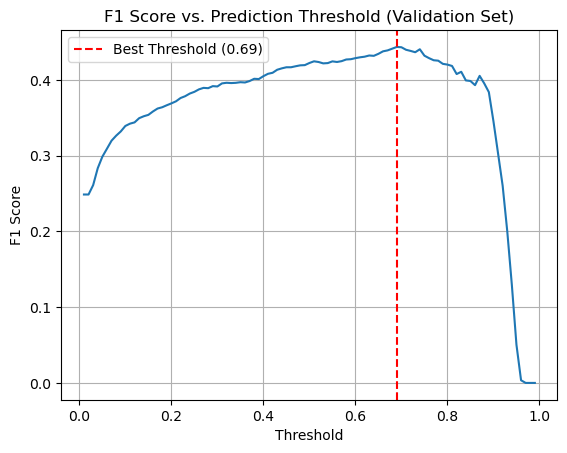

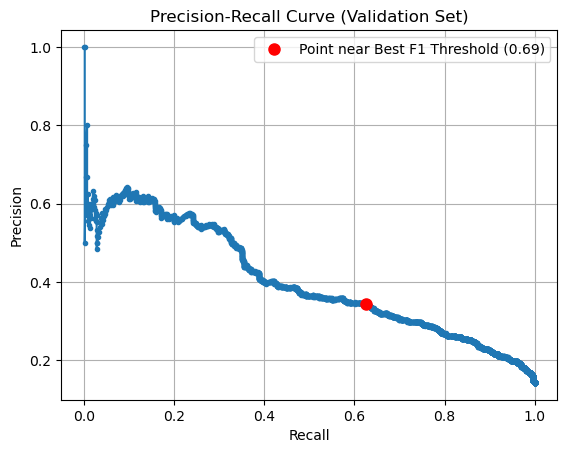


--- Evaluating on Test Set using Optimal Threshold ---

Applying optimized threshold: 0.69

Test Set Performance (Optimized Threshold):
  Test Loss: 0.8716
  Test AUC: 0.7472
  Test F1 (Tuned): 0.3557
  Test Accuracy (Tuned): 0.5915
  Test Precision (Tuned): 0.2312
  Test Recall (Tuned): 0.7709
  Test Confusion Matrix (Tuned):
[[1915 1500]
 [ 134  451]]

Test Set Performance (0.5 Threshold for Comparison):
  Test F1 (0.5): 0.3293
  Test Accuracy (0.5): 0.4785
  Test Precision (0.5): 0.2028
  Test Recall (0.5): 0.8752
  Test Confusion Matrix (0.5):
[[1402 2013]
 [  73  512]]


In [80]:

# --- Find Optimal Threshold on Validation Set ---
print("\n--- Finding Optimal Threshold on Validation Set ---")

model.load_state_dict(torch.load(model_save_path))

# Get validation probabilities and labels
val_metrics_final, val_probs, val_labels = evaluate(model, val_loader, criterion, DEVICE, return_probs=True)
print("Validation Set Performance (0.5 Threshold):")
# print(val_metrics_final) # Print metrics at 0.5 if needed

# Find best threshold based on F1
best_thresh, best_val_f1 = find_best_threshold_f1(val_probs, val_labels)

# --- Final Evaluation on Test Set using Optimal Threshold ---
print("\n--- Evaluating on Test Set using Optimal Threshold ---")

# Get test probabilities and labels
test_metrics_05, test_probs, test_labels = evaluate(model, test_loader, criterion, DEVICE, return_probs=True)

print(f"\nApplying optimized threshold: {best_thresh:.2f}")
# Apply the best threshold found on validation set to the test set probabilities
test_preds_tuned = (test_probs >= best_thresh).astype(int)

# Calculate metrics using the TUNED threshold
auc_test = roc_auc_score(test_labels, test_probs) # AUC doesn't change with threshold
f1_tuned = f1_score(test_labels, test_preds_tuned)
acc_tuned = accuracy_score(test_labels, test_preds_tuned)
prec_tuned = precision_score(test_labels, test_preds_tuned, zero_division=0)
rec_tuned = recall_score(test_labels, test_preds_tuned, zero_division=0)
conf_mat_tuned = confusion_matrix(test_labels, test_preds_tuned)

print("\nTest Set Performance (Optimized Threshold):")
print(f"  Test Loss: {test_metrics_05['loss']:.4f}") # Loss doesn't change
print(f"  Test AUC: {auc_test:.4f}")
print(f"  Test F1 (Tuned): {f1_tuned:.4f}")
print(f"  Test Accuracy (Tuned): {acc_tuned:.4f}")
print(f"  Test Precision (Tuned): {prec_tuned:.4f}")
print(f"  Test Recall (Tuned): {rec_tuned:.4f}")
print(f"  Test Confusion Matrix (Tuned):\n{conf_mat_tuned}")

print("\nTest Set Performance (0.5 Threshold for Comparison):")
print(f"  Test F1 (0.5): {test_metrics_05['f1']:.4f}")
print(f"  Test Accuracy (0.5): {test_metrics_05['accuracy']:.4f}")
print(f"  Test Precision (0.5): {test_metrics_05['precision']:.4f}")
print(f"  Test Recall (0.5): {test_metrics_05['recall']:.4f}")
print(f"  Test Confusion Matrix (0.5):\n{test_metrics_05['conf_matrix']}")

--- Training Finished --- WEIGHTED LOSS
Best validation AUC: 0.7326 achieved at epoch 9

--- Evaluating on Test Set ---
Loaded best model weights for testing.
Test Set Performance:
- Test Loss: 1.1701
-  Test AUC: 0.6321
-  Test F1: 0.3226
-  Test Accuracy: 0.4783
-  Test Precision: 0.1991
-  Test Recall: 0.8496
-  Test Confusion Matrix:
[[1416 1999]
 [  88  497]]

 --- Training Finished --- WEIGHTED SAMPLER
Best validation AUC: 0.7264 achieved at epoch 6

--- Evaluating on Test Set ---
Loaded best model weights for testing.
Test Set Performance:
-  Test Loss: 0.6345
-  Test AUC: 0.6817
-  Test F1: 0.3867
-  Test Accuracy: 0.6875
-  Test Precision: 0.2712
-  Test Recall: 0.6735
-  Test Confusion Matrix:
[[2356 1059]
 [ 191  394]]